In [41]:
!pip install -U ray
!pip install -U gymnasium
!pip install seaborn
!pip install tqdm


# Solving Blackjack with Q-Learning


In this tutorial, we’ll explore and solve the *Blackjack-v1*
environment.

**Blackjack** is one of the most popular casino card games that is also
infamous for being beatable under certain conditions. This version of
the game uses an infinite deck (we draw the cards with replacement), so
counting cards won’t be a viable strategy in our simulated game.
Full documentation can be found at https://gymnasium.farama.org/environments/toy_text/blackjack

**Objective**: To win, your card sum should be greater than the
dealers without exceeding 21.

**Actions**: Agents can pick between two actions:
 - stand (0): the player takes no more cards
 - hit (1): the player will be given another card, however the player could get over 21 and bust

**Approach**: To solve this environment by yourself, you can pick your
favorite discrete RL algorithm. The presented solution uses *Q-learning*
(a model-free RL algorithm).




## Imports and Environment Setup




In [42]:
# Author: Till Zemann
# License: MIT License

from __future__ import annotations

from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.patches import Patch
from tqdm import tqdm

import gymnasium as gym


# Let's start by creating the blackjack environment.
# Note: We are going to follow the rules from Sutton & Barto.
# Other versions of the game can be found below for you to experiment.

env = gym.make("Blackjack-v1", sab=True)

.. code:: py

  # Other possible environment configurations are:

  env = gym.make('Blackjack-v1', natural=True, sab=False)
  # Whether to give an additional reward for starting with a natural blackjack, i.e. starting with an ace and ten (sum is 21).

  env = gym.make('Blackjack-v1', natural=False, sab=False)
  # Whether to follow the exact rules outlined in the book by Sutton and Barto. If `sab` is `True`, the keyword argument `natural` will be ignored.




## Observing the environment

First of all, we call ``env.reset()`` to start an episode. This function
resets the environment to a starting position and returns an initial
``observation``. We usually also set ``done = False``. This variable
will be useful later to check if a game is terminated (i.e., the player wins or loses).




In [43]:
# reset the environment to get the first observation
done = False
observation, info = env.reset()

# observation = (16, 9, False)

Note that our observation is a 3-tuple consisting of 3 values:

-  The players current sum
-  Value of the dealers face-up card
-  Boolean whether the player holds a usable ace (An ace is usable if it
   counts as 11 without busting)




## Executing an action

After receiving our first observation, we are only going to use the
``env.step(action)`` function to interact with the environment. This
function takes an action as input and executes it in the environment.
Because that action changes the state of the environment, it returns
four useful variables to us. These are:

-  ``next_state``: This is the observation that the agent will receive
   after taking the action.
-  ``reward``: This is the reward that the agent will receive after
   taking the action.
-  ``terminated``: This is a boolean variable that indicates whether or
   not the environment has terminated.
-  ``truncated``: This is a boolean variable that also indicates whether
   the episode ended by early truncation, i.e., a time limit is reached.
-  ``info``: This is a dictionary that might contain additional
   information about the environment.

The ``next_state``, ``reward``,  ``terminated`` and ``truncated`` variables are
self-explanatory, but the ``info`` variable requires some additional
explanation. This variable contains a dictionary that might have some
extra information about the environment, but in the Blackjack-v1
environment you can ignore it. For example in Atari environments the
info dictionary has a ``ale.lives`` key that tells us how many lives the
agent has left. If the agent has 0 lives, then the episode is over.

Note that it is not a good idea to call ``env.render()`` in your training
loop because rendering slows down training by a lot. Rather try to build
an extra loop to evaluate and showcase the agent after training.




In [44]:
# sample a random action from all valid actions
action = env.action_space.sample()
# action=1

# execute the action in our environment and receive infos from the environment
observation, reward, terminated, truncated, info = env.step(action)

# observation=(24, 10, False)
# reward=-1.0
# terminated=True
# truncated=False
# info={}

Once ``terminated = True`` or ``truncated=True``, we should stop the
current episode and begin a new one with ``env.reset()``. If you
continue executing actions without resetting the environment, it still
responds but the output won’t be useful for training (it might even be
harmful if the agent learns on invalid data).




## Building an agent

Let’s build a ``Q-learning agent`` to solve *Blackjack-v1*! We’ll need
some functions for picking an action and updating the agents action
values. To ensure that the agents explores the environment, one possible
solution is the ``epsilon-greedy`` strategy, where we pick a random
action with the percentage ``epsilon`` and the greedy action (currently
valued as the best) ``1 - epsilon``.




In [45]:
class BlackjackAgent:
    def __init__(
        self,
        env,
        learning_rate: float,
        initial_epsilon: float,
        epsilon_decay: float,
        final_epsilon: float,
        discount_factor: float = 0.95,
    ):
        """Initialize a Reinforcement Learning agent with an empty dictionary
        of state-action values (q_values), a learning rate and an epsilon.

        Args:
            learning_rate: The learning rate
            initial_epsilon: The initial epsilon value
            epsilon_decay: The decay for epsilon
            final_epsilon: The final epsilon value
            discount_factor: The discount factor for computing the Q-value
        """
        self.q_values = defaultdict(lambda: np.zeros(env.action_space.n))

        self.lr = learning_rate
        self.discount_factor = discount_factor

        self.epsilon = initial_epsilon
        self.epsilon_decay = epsilon_decay
        self.final_epsilon = final_epsilon

        self.training_error = []

    def get_action(self, env, obs: tuple[int, int, bool]) -> int:
        """
        Returns the best action with probability (1 - epsilon)
        otherwise a random action with probability epsilon to ensure exploration.
        """
        # with probability epsilon return a random action to explore the environment
        if np.random.random() < self.epsilon:
            return env.action_space.sample()

        # with probability (1 - epsilon) act greedily (exploit)
        else:
            return int(np.argmax(self.q_values[obs]))

    def update(
        self,
        obs: tuple[int, int, bool],
        action: int,
        reward: float,
        terminated: bool,
        next_obs: tuple[int, int, bool],
    ):
        """Updates the Q-value of an action."""
        future_q_value = (not terminated) * np.max(self.q_values[next_obs])
        temporal_difference = (
            reward + self.discount_factor * future_q_value - self.q_values[obs][action]
        )

        self.q_values[obs][action] = (
            self.q_values[obs][action] + self.lr * temporal_difference
        )
        self.training_error.append(temporal_difference)

    def decay_epsilon(self):
        self.epsilon = max(self.final_epsilon, self.epsilon - self.epsilon_decay)

To train the agent, we will let the agent play one episode (one complete
game is called an episode) at a time and then update it’s Q-values after
each step (one single action in a game is called a step).

The agent will have to experience a lot of episodes to explore the
environment sufficiently.

Now we should be ready to build the training loop.




In [46]:
# hyperparameters
learning_rate = 0.01
n_episodes = 100000
start_epsilon = 1.0
epsilon_decay = start_epsilon / (n_episodes / 2)  # reduce the exploration over time
final_epsilon = 0.1

agent = BlackjackAgent(
    env=env,
    learning_rate=learning_rate,
    initial_epsilon=start_epsilon,
    epsilon_decay=epsilon_decay,
    final_epsilon=final_epsilon,
)

Great, let’s train!

Info: The current hyperparameters are set to quickly train a decent agent.
If you want to converge to the optimal policy, try increasing
the n_episodes by 10x and lower the learning_rate (e.g. to 0.001).




In [47]:
env = gym.wrappers.RecordEpisodeStatistics(env, n_episodes)
for episode in tqdm(range(n_episodes)):
    obs, info = env.reset()
    done = False

    # play one episode
    while not done:
        action = agent.get_action(env, obs)
        next_obs, reward, terminated, truncated, info = env.step(action)

        # update the agent
        agent.update(obs, action, reward, terminated, next_obs)

        # update if the environment is done and the current obs
        done = terminated or truncated
        obs = next_obs

    agent.decay_epsilon()

100%|██████████| 100000/100000 [00:29<00:00, 3367.91it/s]


## Visualizing the training




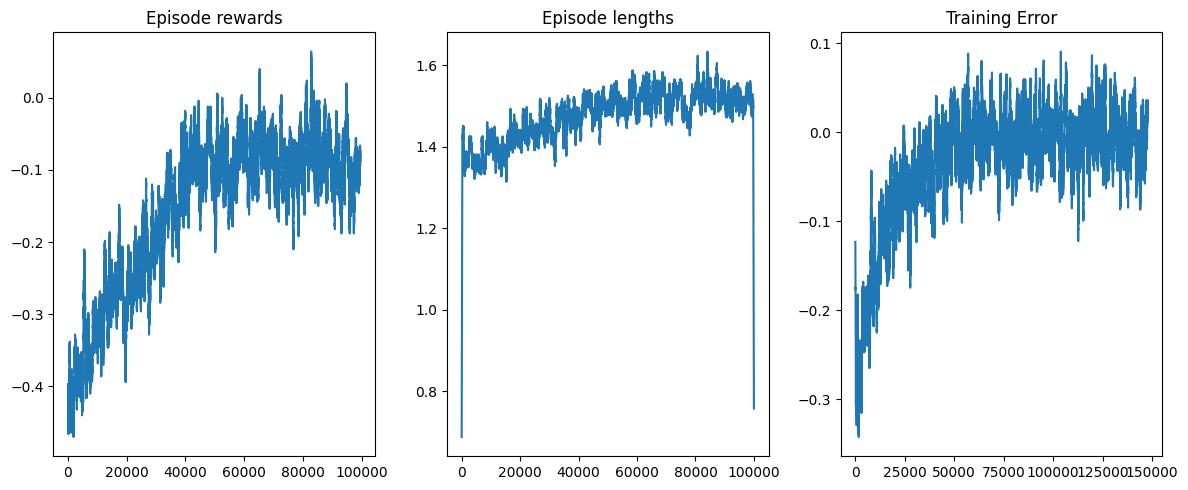

In [48]:
rolling_length = 500
fig, axs = plt.subplots(ncols=3, figsize=(12, 5))
axs[0].set_title("Episode rewards")
# compute and assign a rolling average of the data to provide a smoother graph
reward_moving_average = (
    np.convolve(
        np.array(env.return_queue).flatten(), np.ones(rolling_length), mode="valid"
    )
    / rolling_length
)
axs[0].plot(range(len(reward_moving_average)), reward_moving_average)
axs[1].set_title("Episode lengths")
length_moving_average = (
    np.convolve(
        np.array(env.length_queue).flatten(), np.ones(rolling_length), mode="same"
    )
    / rolling_length
)
axs[1].plot(range(len(length_moving_average)), length_moving_average)
axs[2].set_title("Training Error")
training_error_moving_average = (
    np.convolve(np.array(agent.training_error), np.ones(rolling_length), mode="same")
    / rolling_length
)
axs[2].plot(range(len(training_error_moving_average)), training_error_moving_average)
plt.tight_layout()
plt.show()

<img src="file://_static/img/tutorials/blackjack_training_plots.png">




## Visualising the policy



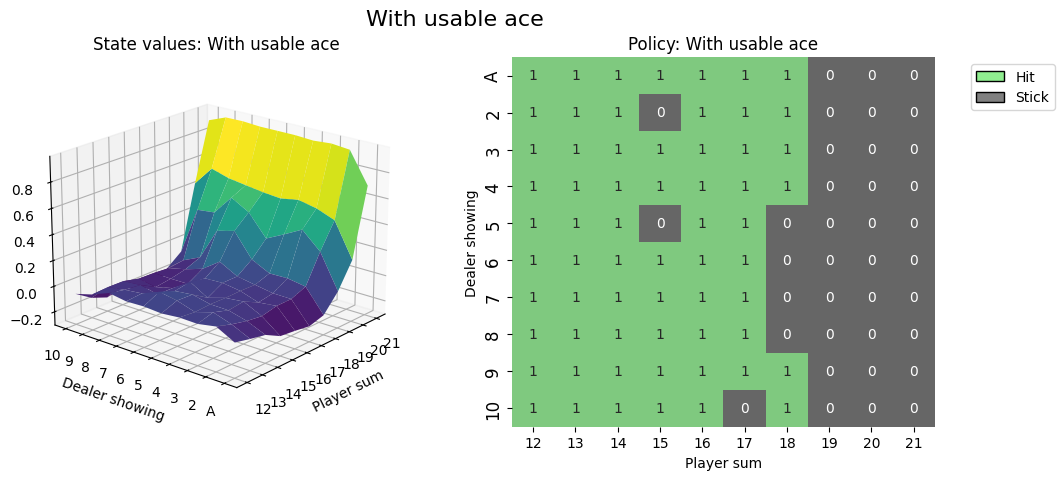

In [49]:
def create_grids(agent, usable_ace=False):
    """Create value and policy grid given an agent."""
    # convert our state-action values to state values
    # and build a policy dictionary that maps observations to actions
    state_value = defaultdict(float)
    policy = defaultdict(int)
    for obs, action_values in agent.q_values.items():
        state_value[obs] = float(np.max(action_values))
        policy[obs] = int(np.argmax(action_values))

    player_count, dealer_count = np.meshgrid(
        # players count, dealers face-up card
        np.arange(12, 22),
        np.arange(1, 11),
    )

    # create the value grid for plotting
    value = np.apply_along_axis(
        lambda obs: state_value[(obs[0], obs[1], usable_ace)],
        axis=2,
        arr=np.dstack([player_count, dealer_count]),
    )
    value_grid = player_count, dealer_count, value

    # create the policy grid for plotting
    policy_grid = np.apply_along_axis(
        lambda obs: policy[(obs[0], obs[1], usable_ace)],
        axis=2,
        arr=np.dstack([player_count, dealer_count]),
    )
    return value_grid, policy_grid


def create_plots(value_grid, policy_grid, title: str):
    """Creates a plot using a value and policy grid."""
    # create a new figure with 2 subplots (left: state values, right: policy)
    player_count, dealer_count, value = value_grid
    fig = plt.figure(figsize=plt.figaspect(0.4))
    fig.suptitle(title, fontsize=16)

    # plot the state values
    ax1 = fig.add_subplot(1, 2, 1, projection="3d")
    ax1.plot_surface(
        player_count,
        dealer_count,
        value,
        rstride=1,
        cstride=1,
        cmap="viridis",
        edgecolor="none",
    )
    plt.xticks(range(12, 22), range(12, 22))
    plt.yticks(range(1, 11), ["A"] + list(range(2, 11)))
    ax1.set_title(f"State values: {title}")
    ax1.set_xlabel("Player sum")
    ax1.set_ylabel("Dealer showing")
    ax1.zaxis.set_rotate_label(False)
    ax1.set_zlabel("Value", fontsize=14, rotation=90)
    ax1.view_init(20, 220)

    # plot the policy
    fig.add_subplot(1, 2, 2)
    ax2 = sns.heatmap(policy_grid, linewidth=0, annot=True, cmap="Accent_r", cbar=False)
    ax2.set_title(f"Policy: {title}")
    ax2.set_xlabel("Player sum")
    ax2.set_ylabel("Dealer showing")
    ax2.set_xticklabels(range(12, 22))
    ax2.set_yticklabels(["A"] + list(range(2, 11)), fontsize=12)

    # add a legend
    legend_elements = [
        Patch(facecolor="lightgreen", edgecolor="black", label="Hit"),
        Patch(facecolor="grey", edgecolor="black", label="Stick"),
    ]
    ax2.legend(handles=legend_elements, bbox_to_anchor=(1.3, 1))
    return fig


# state values & policy with usable ace (ace counts as 11)
value_grid, policy_grid = create_grids(agent, usable_ace=True)
fig1 = create_plots(value_grid, policy_grid, title="With usable ace")
plt.show()

<img src="file://_static/img/tutorials/blackjack_with_usable_ace.png">




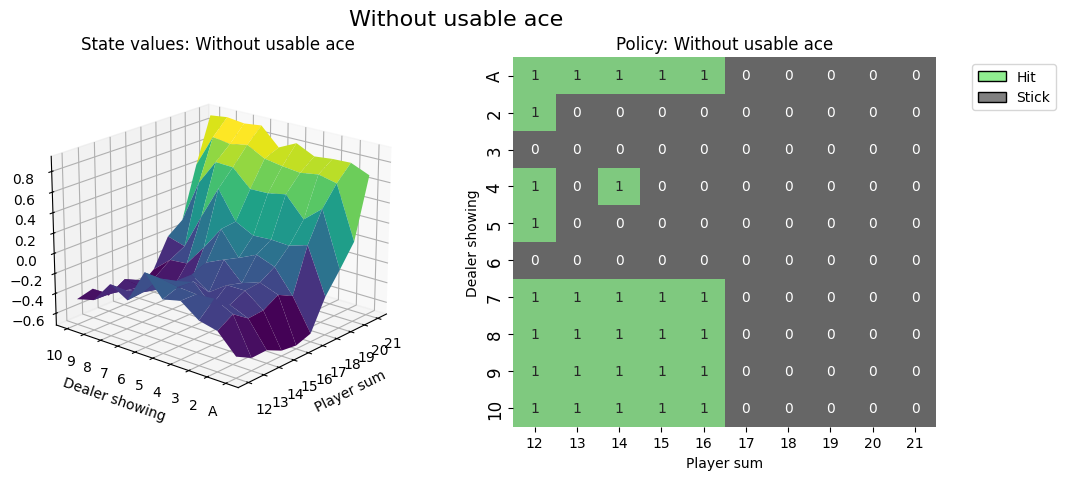

In [50]:
# state values & policy without usable ace (ace counts as 1)
value_grid, policy_grid = create_grids(agent, usable_ace=False)
fig2 = create_plots(value_grid, policy_grid, title="Without usable ace")
plt.show()

<img src="file://_static/img/tutorials/blackjack_without_usable_ace.png">

It's good practice to call env.close() at the end of your script,
so that any used resources by the environment will be closed.




## Personal Code:


Training with 100 episodes


Running 100 episodes: 100%|██████████| 100/100 [00:00<00:00, 3190.60it/s]


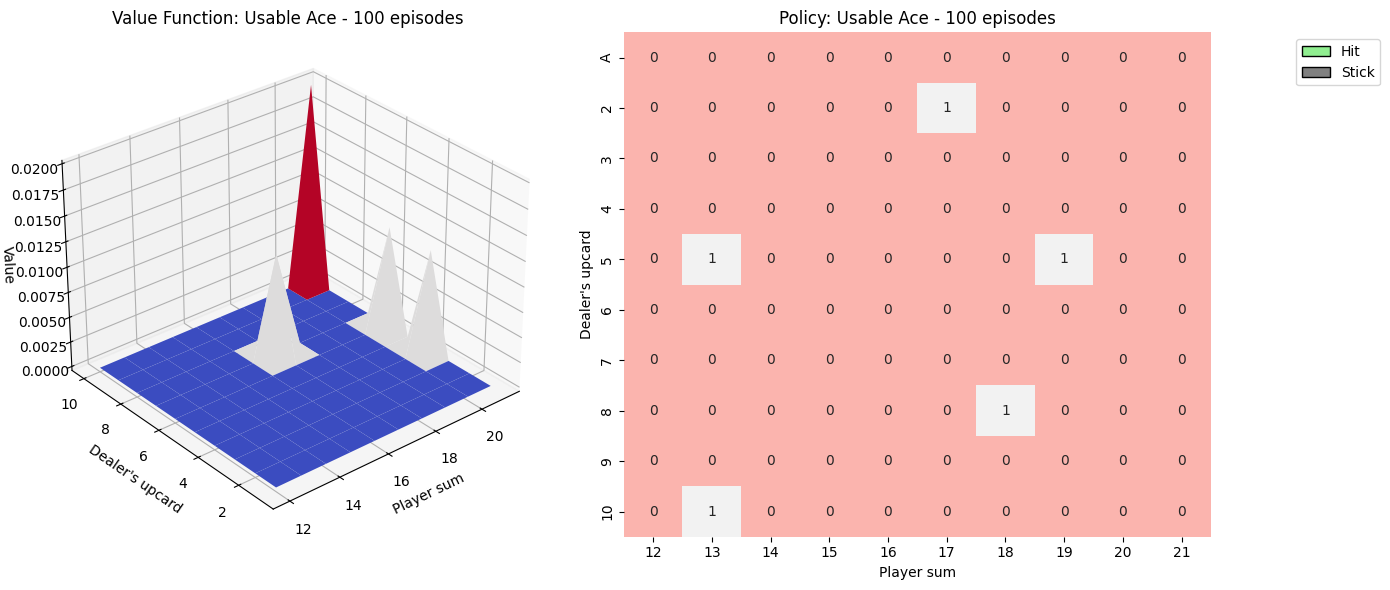

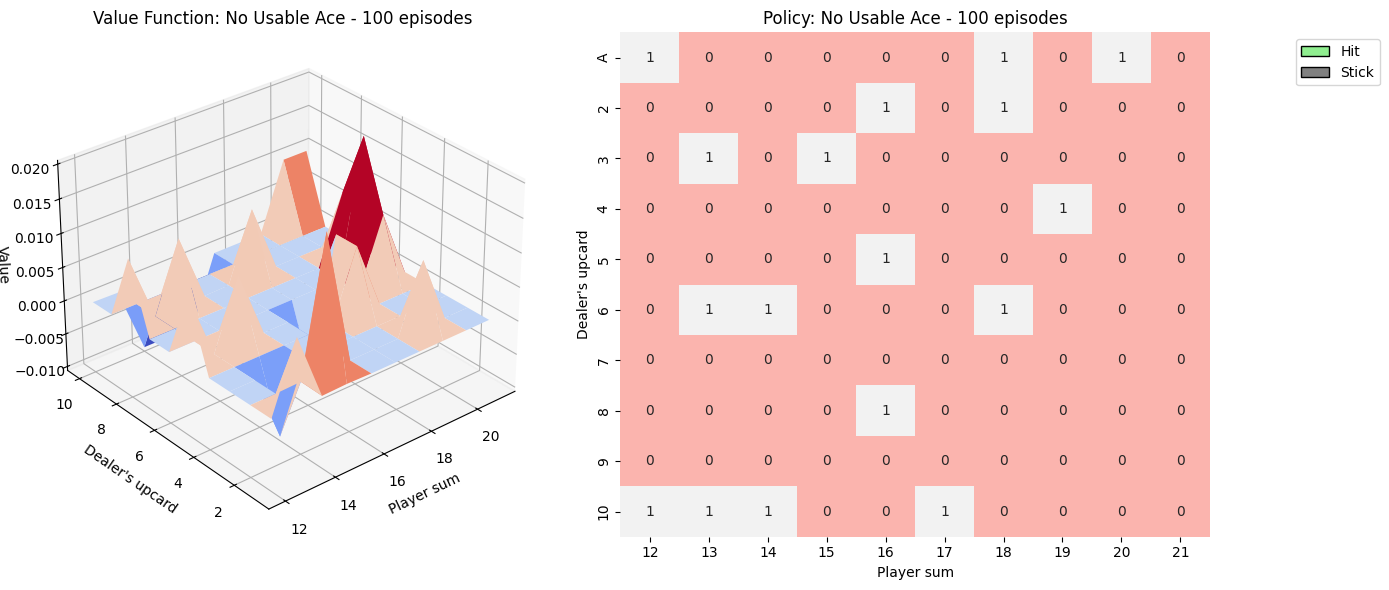


Training with 1000 episodes


Running 1000 episodes: 100%|██████████| 1000/1000 [00:00<00:00, 3581.29it/s]


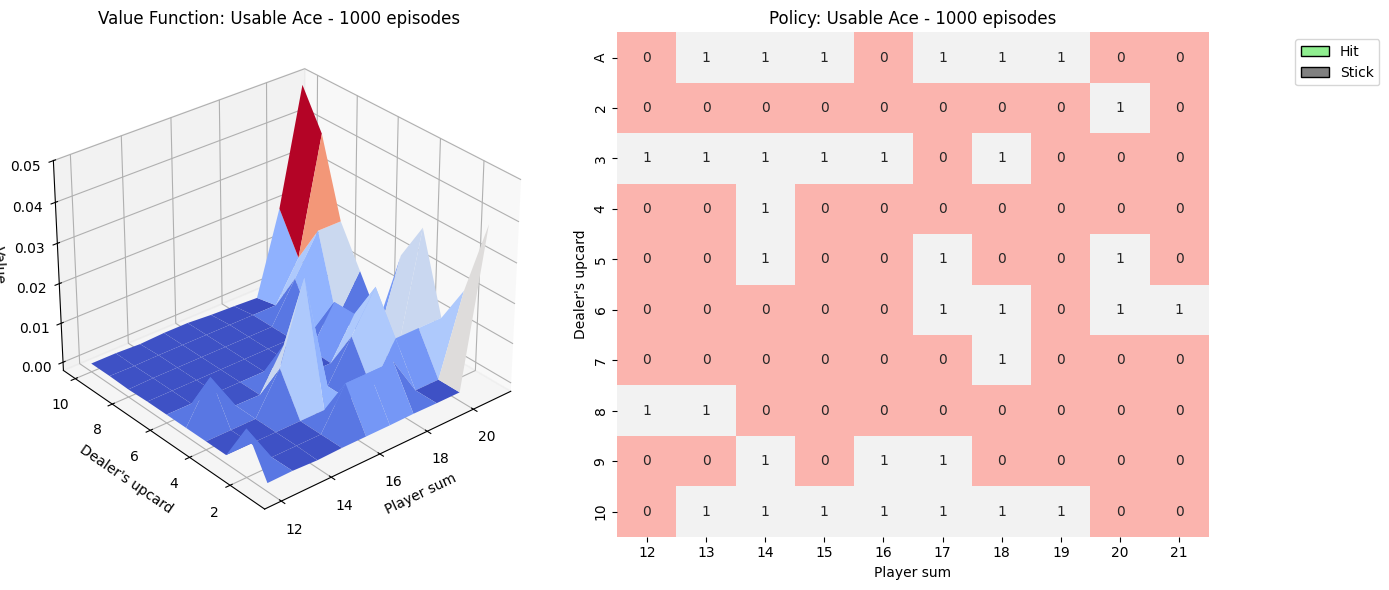

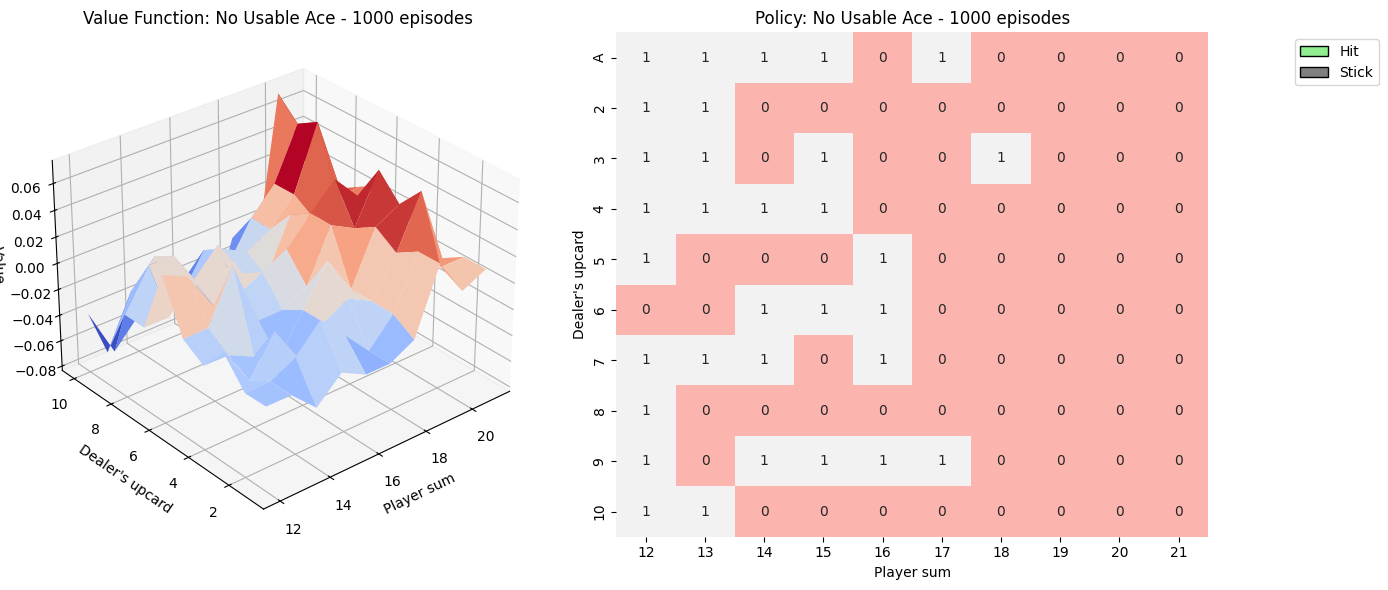


Training with 10000 episodes


Running 10000 episodes: 100%|██████████| 10000/10000 [00:02<00:00, 3559.82it/s]


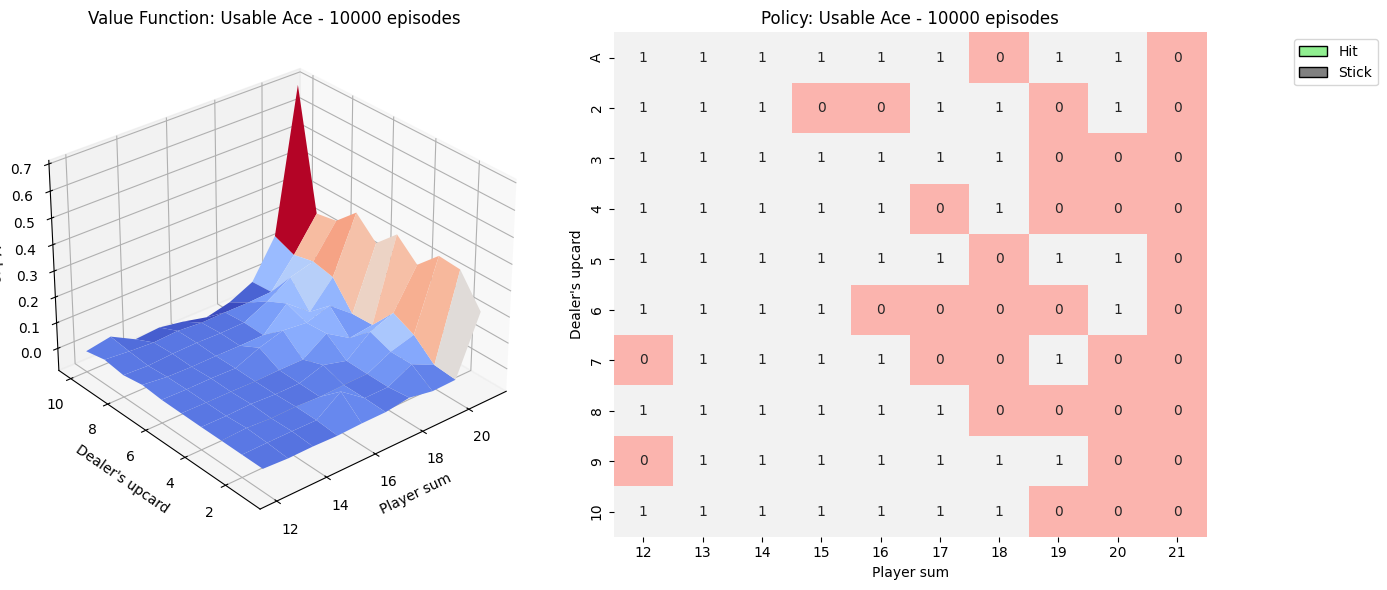

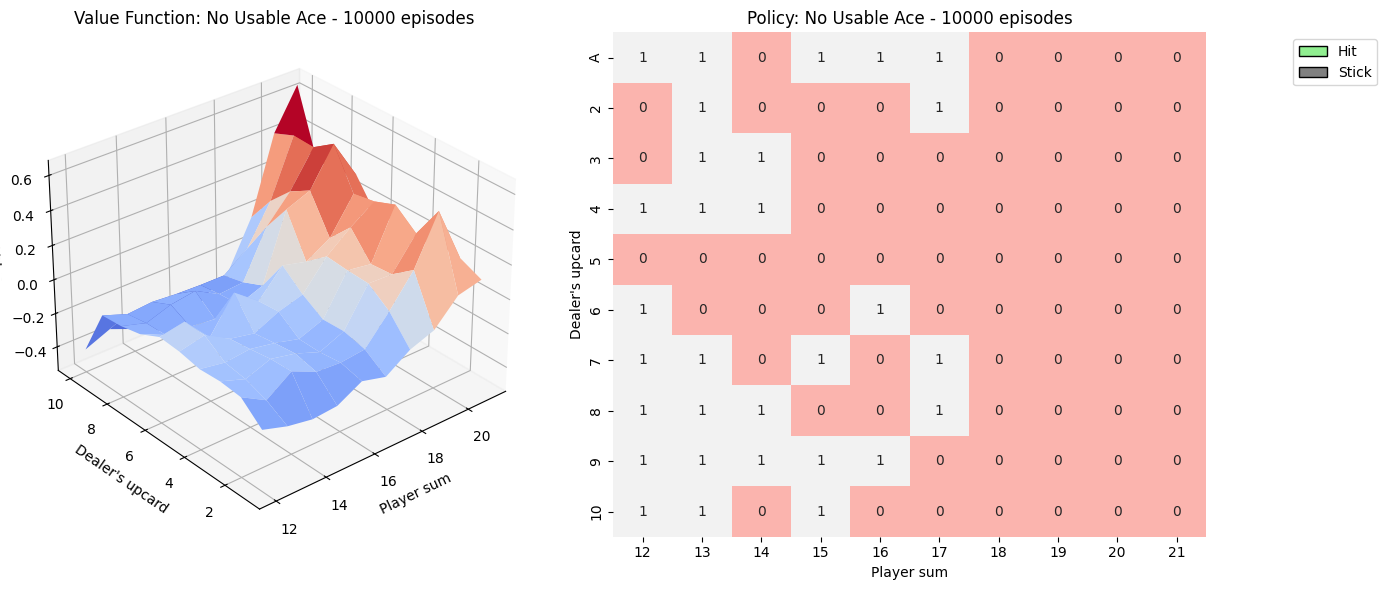


Training with 50000 episodes


Running 50000 episodes: 100%|██████████| 50000/50000 [00:14<00:00, 3440.95it/s]


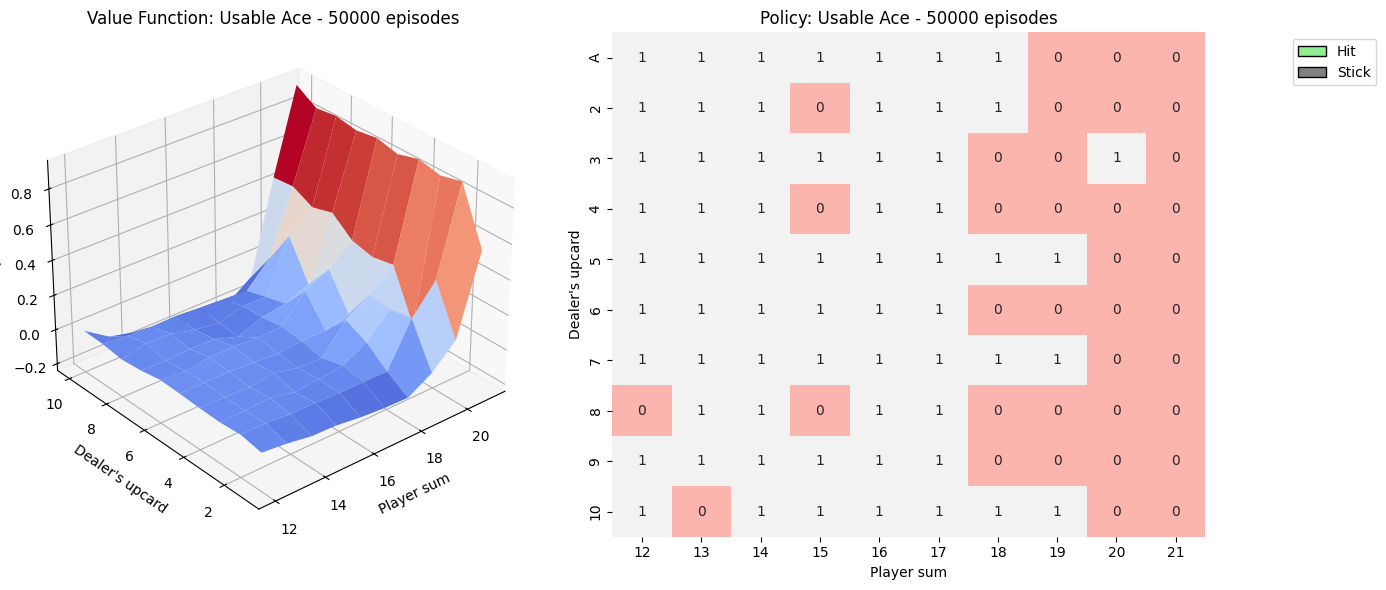

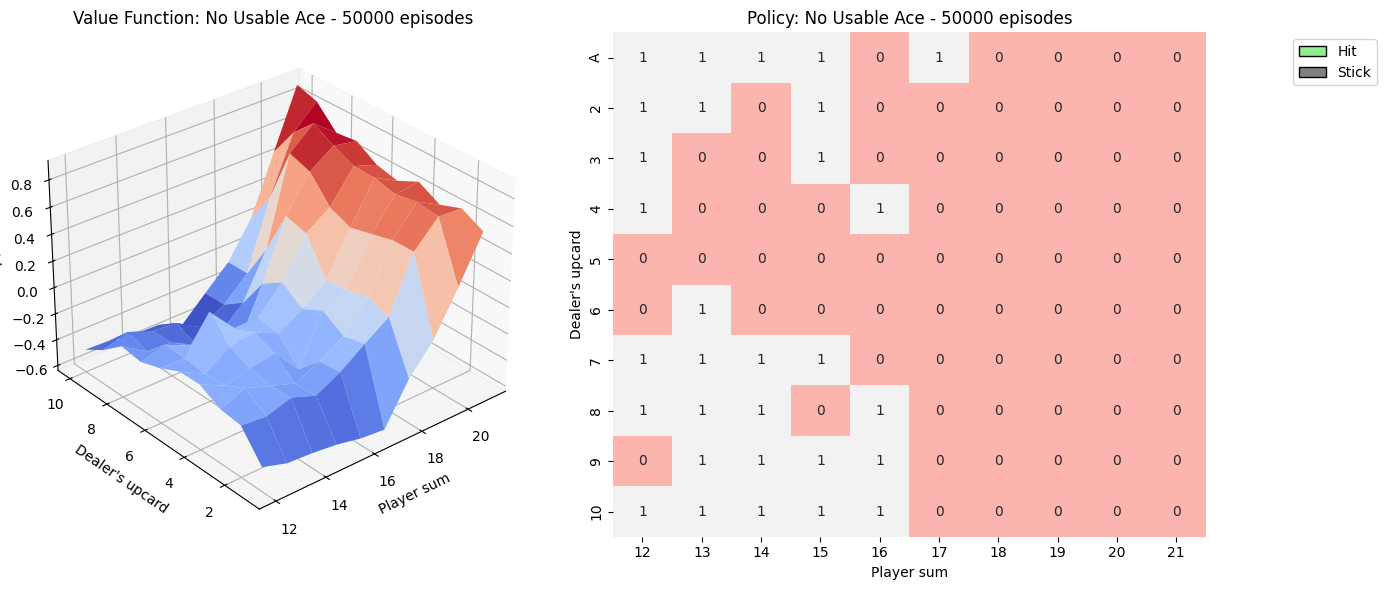


Training with 100000 episodes


Running 100000 episodes: 100%|██████████| 100000/100000 [00:29<00:00, 3410.15it/s]


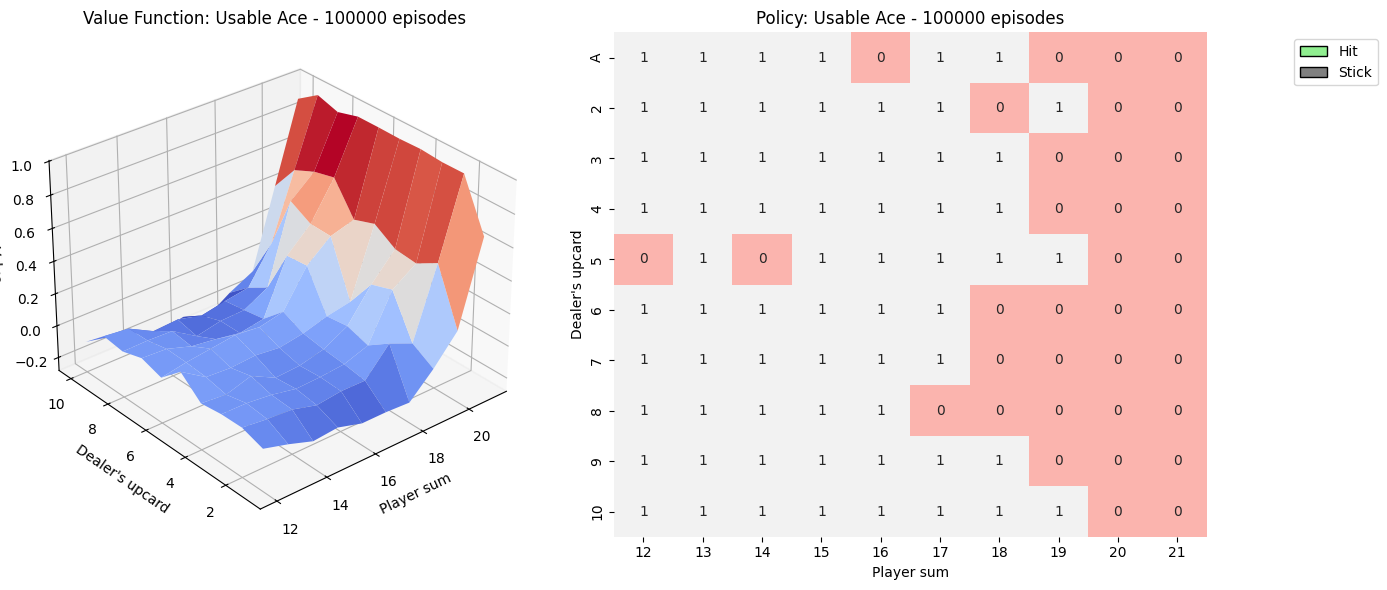

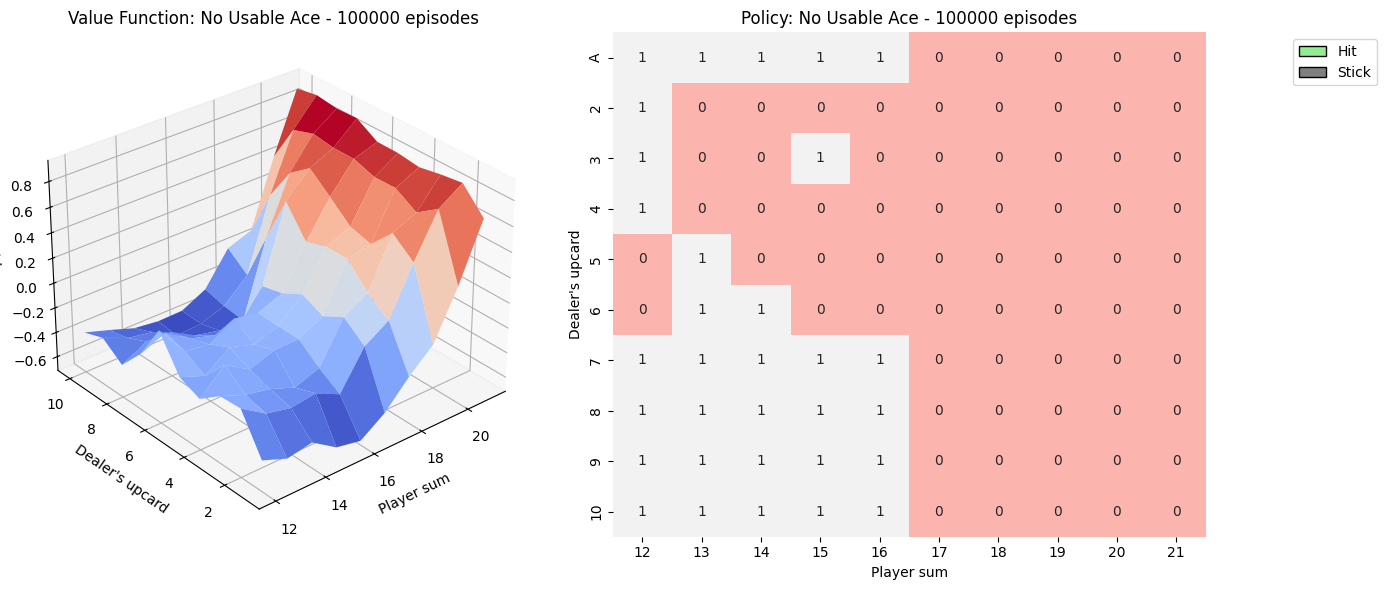


Training with 200000 episodes


Running 200000 episodes: 100%|██████████| 200000/200000 [00:58<00:00, 3411.65it/s]


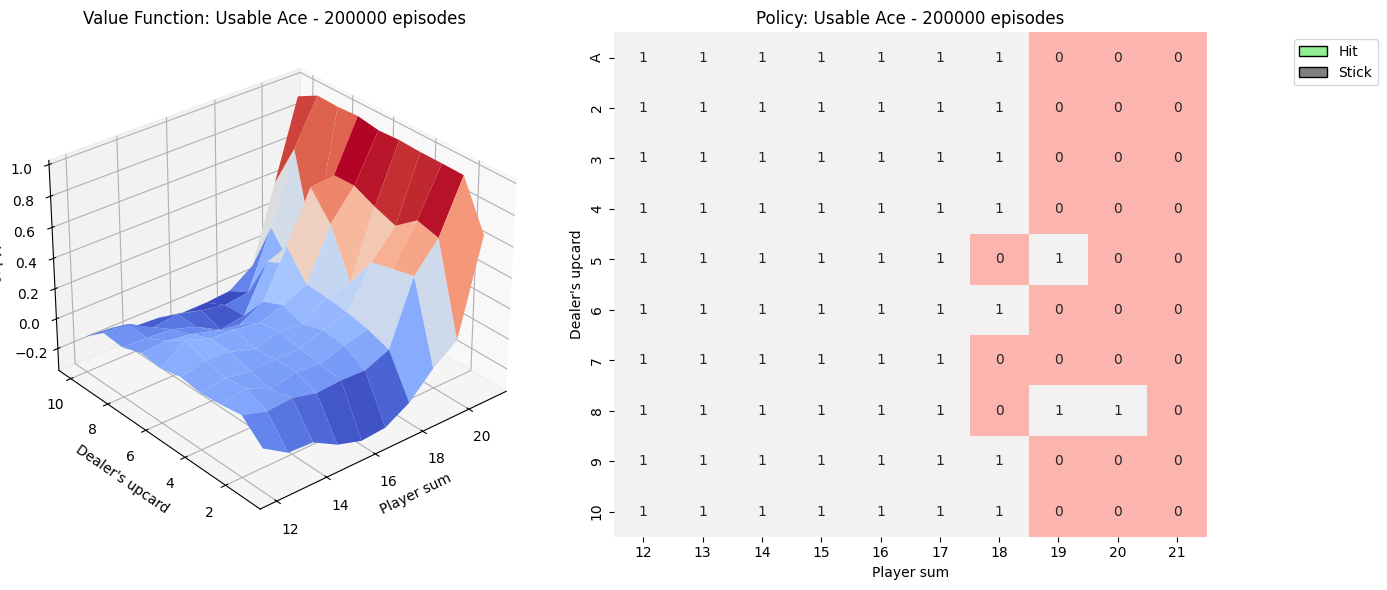

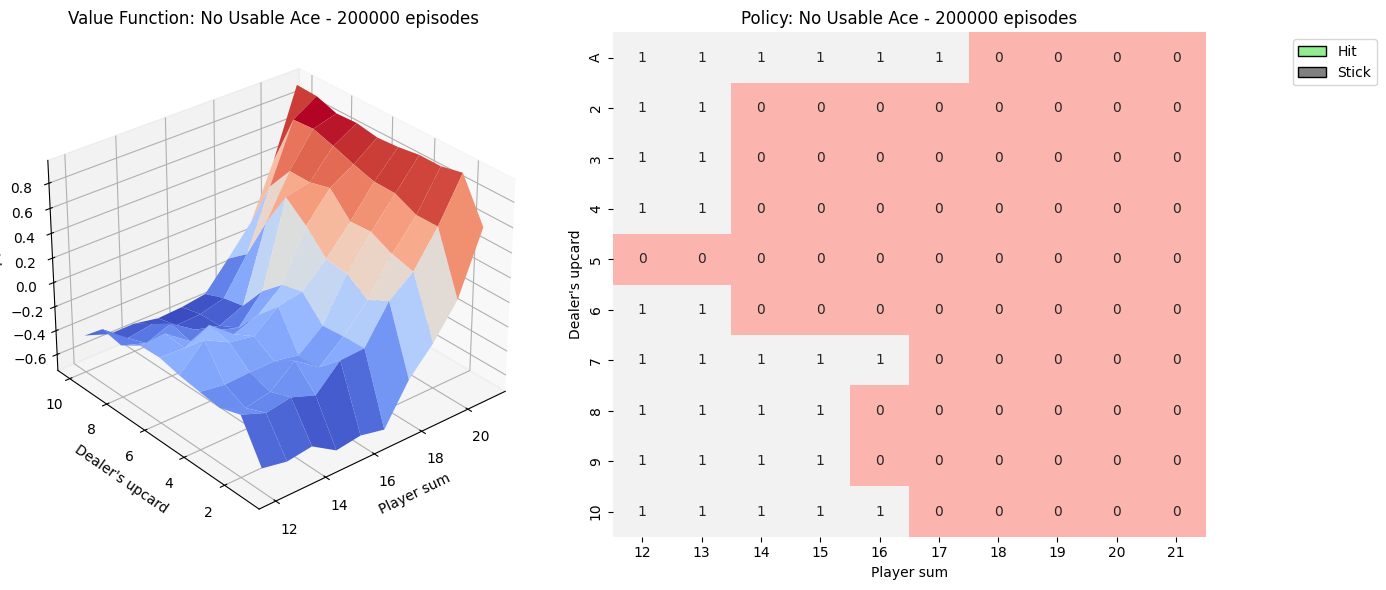

In [51]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from collections import defaultdict
from matplotlib.patches import Patch
from mpl_toolkits.mplot3d import Axes3D  # Import 3D plotting

import gymnasium as gym

# BlackjackAgent class
class QLearningAgent:
    def __init__(self, env, alpha=0.01, gamma=0.95, initial_epsilon=1.0, min_epsilon=0.1, epsilon_decay=0.999):
        """Initialize agent's learning parameters and Q-table."""
        self.q_table = defaultdict(lambda: np.zeros(env.action_space.n))  
        self.alpha = alpha  
        self.gamma = gamma  
        self.epsilon = initial_epsilon  
        self.min_epsilon = min_epsilon  
        self.epsilon_decay = epsilon_decay  
        self.error_log = []  

    def select_action(self, state, env):
        """Select action using epsilon-greedy policy."""
        if np.random.rand() < self.epsilon:
            return env.action_space.sample()  
        else:
            return np.argmax(self.q_table[state])  

    def update_q(self, state, action, reward, next_state, done):
        """Update Q-value based on observed experience."""
        q_future = (not done) * np.max(self.q_table[next_state])  
        td_error = reward + self.gamma * q_future - self.q_table[state][action]
        self.q_table[state][action] += self.alpha * td_error  
        self.error_log.append(td_error)

    def reduce_epsilon(self):
        """Decay epsilon after each episode."""
        self.epsilon = max(self.min_epsilon, self.epsilon * self.epsilon_decay)

# Training
def run_training(env, agent, episodes):
    for ep in tqdm(range(episodes), desc=f"Running {episodes} episodes"):
        state, _ = env.reset()
        done = False
        while not done:
            action = agent.select_action(state, env)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            agent.update_q(state, action, reward, next_state, done)
            state = next_state
        agent.reduce_epsilon()

# Visualization
def generate_grids(agent, has_usable_ace=False):
    value_map = defaultdict(float)
    policy_map = defaultdict(int)

    for state, action_values in agent.q_table.items():
        value_map[state] = np.max(action_values)
        policy_map[state] = np.argmax(action_values)

    player_sum, dealer_upcard = np.meshgrid(np.arange(12, 22), np.arange(1, 11))
    
    value_grid = np.apply_along_axis(
        lambda obs: value_map.get((obs[0], obs[1], has_usable_ace), 0),
        axis=2,
        arr=np.dstack([player_sum, dealer_upcard])
    )

    policy_grid = np.apply_along_axis(
        lambda obs: policy_map.get((obs[0], obs[1], has_usable_ace), 0),
        axis=2,
        arr=np.dstack([player_sum, dealer_upcard])
    )

    return player_sum, dealer_upcard, value_grid, policy_grid

# Visualization
def visualize_grids(player_sum, dealer_upcard, value_grid, policy_grid, title):
    fig = plt.figure(figsize=(14, 6))

    # 3D plot
    ax1 = fig.add_subplot(1, 2, 1, projection='3d')
    ax1.plot_surface(player_sum, dealer_upcard, value_grid, cmap='coolwarm', edgecolor='none')
    ax1.set_title(f"Value Function: {title}")
    ax1.set_xlabel("Player sum")
    ax1.set_ylabel("Dealer's upcard")
    ax1.set_zlabel("Value")
    ax1.view_init(30, 230)

    # 2D heatmap
    ax2 = fig.add_subplot(1, 2, 2)
    sns.heatmap(policy_grid, annot=True, fmt="d", cmap="Pastel1", ax=ax2, cbar=False)
    ax2.set_title(f"Policy: {title}")
    ax2.set_xlabel("Player sum")
    ax2.set_ylabel("Dealer's upcard")
    ax2.set_xticklabels(range(12, 22))
    ax2.set_yticklabels(["A"] + list(range(2, 11)))

    # Legend
    legend_elements = [Patch(facecolor="lightgreen", edgecolor="black", label="Hit"),
                       Patch(facecolor="grey", edgecolor="black", label="Stick")]
    ax2.legend(handles=legend_elements, bbox_to_anchor=(1.3, 1))
    
    plt.tight_layout()
    plt.show()

# Main loop
env = gym.make("Blackjack-v1", sab=True)
episode_tests = [100, 1000, 10000, 50000, 100000, 200000]

for episodes in episode_tests:
    print(f"\nTraining with {episodes} episodes")
    
    agent = QLearningAgent(env)
    run_training(env, agent, episodes)

    # (Usable ace/non-usable ace)
    player_sum, dealer_upcard, value_grid, policy_grid = generate_grids(agent, has_usable_ace=True)
    visualize_grids(player_sum, dealer_upcard, value_grid, policy_grid, f"Usable Ace - {episodes} episodes")

    player_sum, dealer_upcard, value_grid, policy_grid = generate_grids(agent, has_usable_ace=False)
    visualize_grids(player_sum, dealer_upcard, value_grid, policy_grid, f"No Usable Ace - {episodes} episodes")


# Reflections:

### 100 to 1,000 Episodes:

Quality: Poor

The agent is still figuring things out and hasn't played enough games to learn what works well.

### 10,000 Episodes:

Quality: Getting better

The agent is starting to get the hang of it after playing more games, so it's learning from its experiences.

### 50,000 Episodes:

Quality: Good

The agent has played enough games to pick up solid strategies and is making smarter moves most of the time.

### 100,000 Episodes:

Quality: Very good

The agent has learned most of the best strategies and makes strong decisions.

### 200,000 Episodes:

Quality: Near-optimal

The agent has mastered almost every possible situation.


10,000-50,000 episodes is sufficient for a good policy, but 100,000 or more can get it to a good policy for this environment.